# EPAM04

## Librarys

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,silhouette_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as stats



In [ ]:
# Define the URL of the raw CSV file on GitHub
url_regression = "https://raw.githubusercontent.com/AysenurYrr/ML-Lab/refs/heads/main/UCI%20Air%20Quality/dataset/AirQualityUCI.csv"
url_classification = "https://raw.githubusercontent.com/AysenurYrr/ML-Lab/refs/heads/main/Rain%20in%20Australia/dataset/weatherAUS.csv"

## 1. Regression Problem

### A: Data Preprocessing

I am not performing the EDA sections as I have already completed them previously, and there are no scoring criteria for this part. The Data Preprocessing steps are carried over from my previous assignment; therefore, there are not many insights to be drawn.

In [ ]:
# Load the dataset into a pandas DataFrame
df_r = pd.read_csv(url_regression, sep=';',  na_values=-200, decimal = ',')
df_r = df_r.drop(columns=['Unnamed: 15', 'Unnamed: 16','NMHC(GT)'])
# Display the resulting DataFrame

df_r.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


#### Drop Null Date

In [ ]:
print(f"Null date rows before drop: {df_r['Date'].isna().sum()}")
# Delete rows containing NaT (null) values
df_r = df_r.dropna(subset=['Date'])

# Check after deletion
print(f"Null date rows after drop: {df_r['Date'].isna().sum()}")


Null date rows before drop: 114
Null date rows after drop: 0


#### Date to index

In [ ]:
# Replace '.' with ':' in the Time column
df_r['Time'] = df_r['Time'].str.replace('.', ':')

# Combine Date and Time into a single column
df_r['Date'] = df_r['Date'] + ' ' + df_r['Time']

# Convert Date to datetime, specifying the correct format and dayfirst=True
df_r['Date'] = pd.to_datetime(df_r['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce', dayfirst=True)

# Set Date as the index
df_r = df_r.set_index('Date')

# Drop the Time column as it's no longer needed
df_r.drop(['Time'], axis=1, inplace=True)

# Display the first few rows
df_r.head()


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
df_r = df_r.sort_index()
train_r, test_r = df_r.iloc[:8000,:], df_r.iloc[8000:,:]

In [ ]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   C6H6(GT)       8991 non-null   float64
 3   PT08.S2(NMHC)  8991 non-null   float64
 4   NOx(GT)        7718 non-null   float64
 5   PT08.S3(NOx)   8991 non-null   float64
 6   NO2(GT)        7715 non-null   float64
 7   PT08.S4(NO2)   8991 non-null   float64
 8   PT08.S5(O3)    8991 non-null   float64
 9   T              8991 non-null   float64
 10  RH             8991 non-null   float64
 11  AH             8991 non-null   float64
dtypes: float64(12)
memory usage: 950.3 KB


#### Handling Missing Values

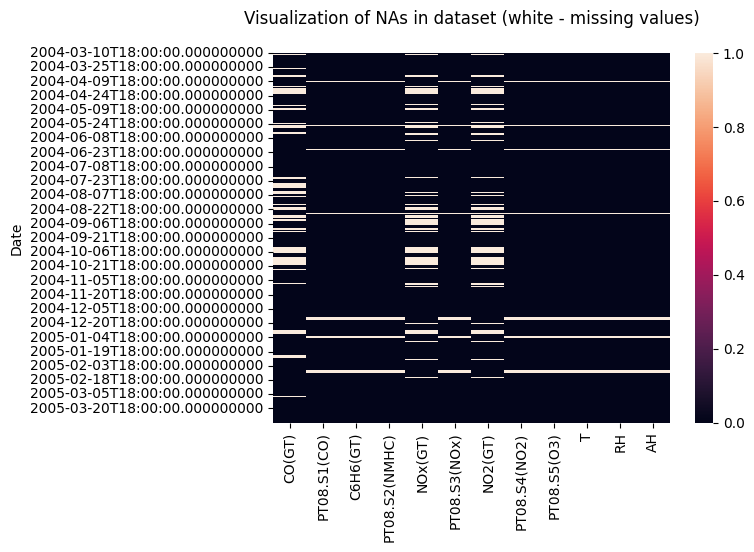

In [ ]:
sns.heatmap(df_r.isna());
plt.title('Visualization of NAs in dataset (white - missing values)\n');

In [ ]:
print('Maximum number of missing values = number of columns in df = {}'.format(len(df_r.columns)))

Maximum number of missing values = number of columns in df = 12


Remove rows that have more than 10 missing values:

In [ ]:
bad_rows = df_r[df_r.shape[1] - df_r.count(axis=1) > 10].index
df_r.drop(bad_rows, axis = 0, inplace = True)

In [ ]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9313 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7661 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   C6H6(GT)       8991 non-null   float64
 3   PT08.S2(NMHC)  8991 non-null   float64
 4   NOx(GT)        7718 non-null   float64
 5   PT08.S3(NOx)   8991 non-null   float64
 6   NO2(GT)        7715 non-null   float64
 7   PT08.S4(NO2)   8991 non-null   float64
 8   PT08.S5(O3)    8991 non-null   float64
 9   T              8991 non-null   float64
 10  RH             8991 non-null   float64
 11  AH             8991 non-null   float64
dtypes: float64(12)
memory usage: 945.9 KB


Also, there're some missing values in target variable. There's nothing we can do, so just remove those rows:

In [ ]:
df_r.drop(df_r[df_r['C6H6(GT)'].isnull()].index, axis = 0, inplace = True)

df_r.shape

(8991, 12)

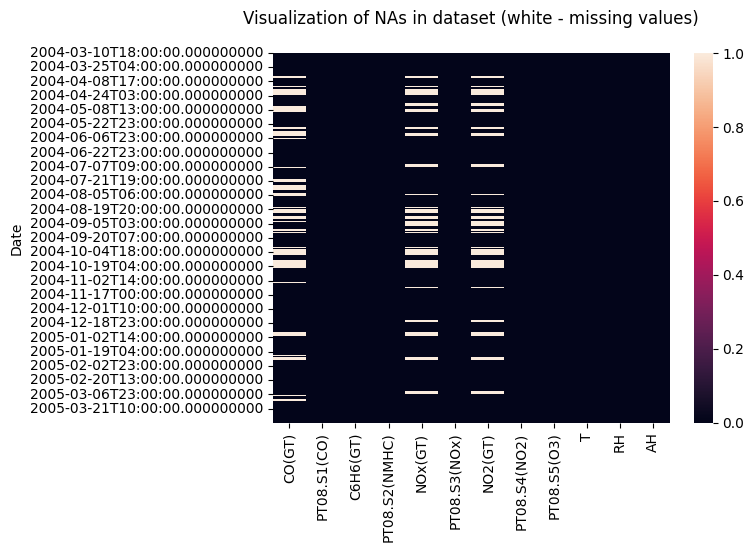

In [ ]:
sns.heatmap(df_r.isna());
plt.title('Visualization of NAs in dataset (white - missing values)\n');

In [ ]:
df_r = df_r.sort_index()
train, test = df_r.iloc[:8000,:], df_r.iloc[8000:,:]
train.shape , test.shape

((8000, 12), (991, 12))

We see, that some of variables' distributions are skewed, so to fill NAs with _medians_ would be the best strategy.
We'll save medians in train df for future use in test df:

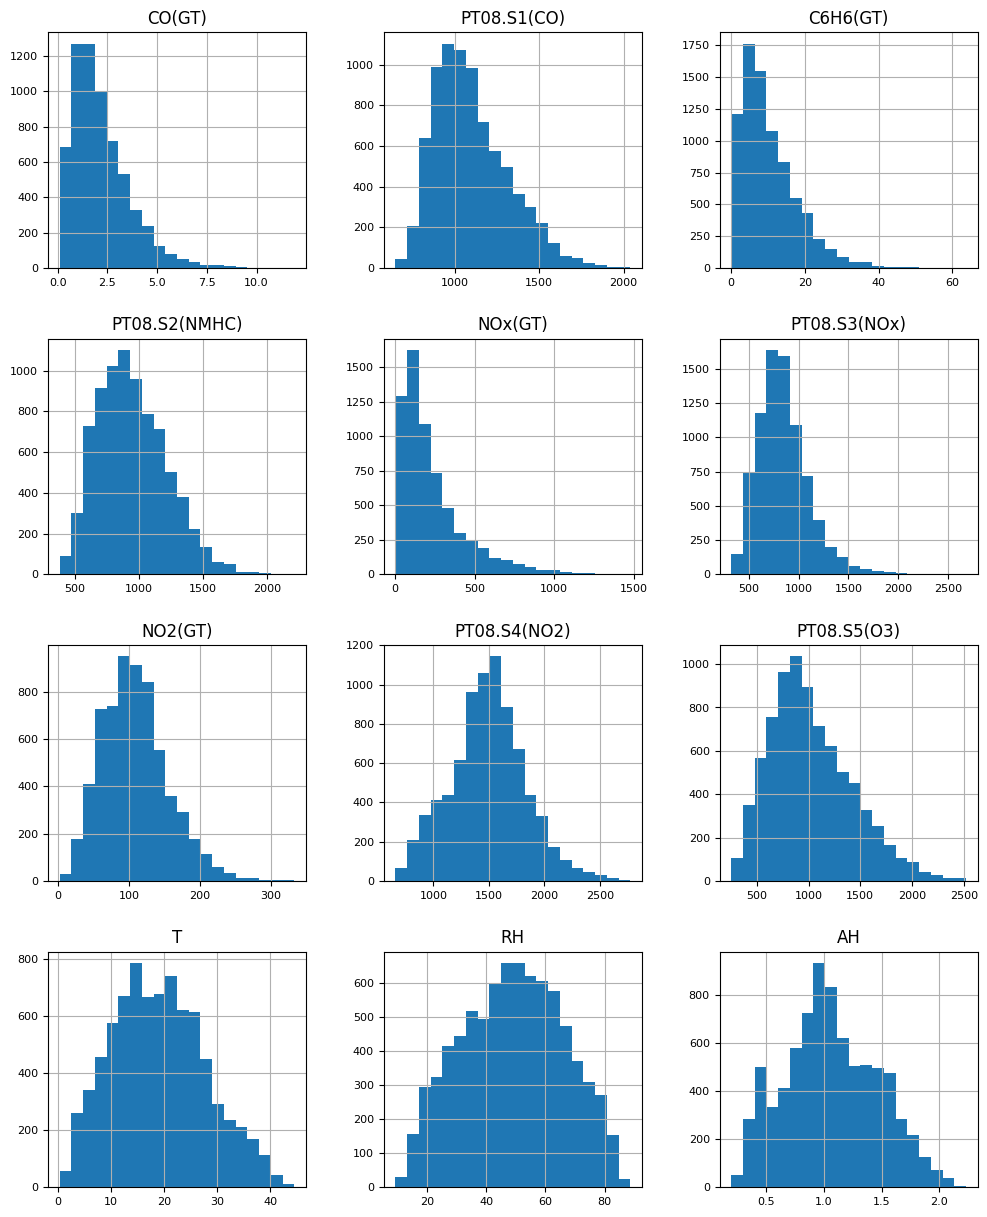

In [ ]:
train.hist(figsize=(12, 15), bins=20, xlabelsize=8, ylabelsize=8);

In [ ]:
to_fill = {}
for i in train.columns:
    to_fill[i] = np.nanmedian(train[i])
train = train.fillna(value = to_fill)
test = test.fillna(value = to_fill)

train.count() / train.shape[0]

,0
CO(GT),1.0
PT08.S1(CO),1.0
C6H6(GT),1.0
PT08.S2(NMHC),1.0
NOx(GT),1.0
PT08.S3(NOx),1.0
NO2(GT),1.0
PT08.S4(NO2),1.0
PT08.S5(O3),1.0
T,1.0


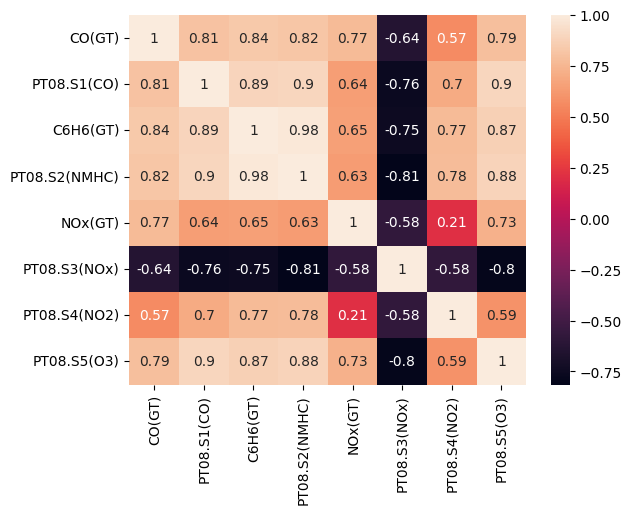

In [ ]:
corr = train.corr()
condition = np.absolute(corr['C6H6(GT)']) > 0.6
top_corr = corr.loc[condition,condition]
data_top_corr = train.loc[:,top_corr.columns]
sns.heatmap(top_corr, annot=True);

In [ ]:
top_corr_features = list(data_top_corr.columns)
top_corr_features.remove('C6H6(GT)')

#### Train Test Split and Scale

I had previously decided to use MinMax scaling in my earlier assigment.

In [ ]:
# Split train data into features and target
train_X = train.drop(columns=['C6H6(GT)'])
train_y = train['C6H6(GT)']

# Select top correlated features from train data
train_selected_X = train_X[top_corr_features]

# Apply MinMaxScaler to train selected features
scaler = MinMaxScaler()  # Initialize the scaler
train_X_minmax = pd.DataFrame(scaler.fit_transform(train_selected_X), columns=train_selected_X.columns)

# Split test data into features and target
test_X = test.drop(columns=['C6H6(GT)'])
test_y = test['C6H6(GT)']

# Select top correlated features from test data
test_selected_X = test_X[top_corr_features]

# Scale test data using the same scaler
test_scaled_X = pd.DataFrame(scaler.transform(test_selected_X), columns=test_selected_X.columns)

### B. Modelling

#### Functions

##### Train and Evaluate Model

The train_and_evaluate function is designed for regression tasks. Here's an explanation of its purpose, the parameters it uses.

MSE: It is chosen because it penalizes large errors more heavily, making it sensitive to significant deviations. ower MSE indicates better model performance.

R² explains the proportion of variance in the target variable that is predictable from the input features. A value close to 1 indicates that the model fits the data well, while lower values signify poor performance.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """
    Trains the given model and evaluates it on the test set.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, r2


##### Hyperparameter Tuning

In time series problems, we cannot use future data to train the model, as it would lead to unrealistic results. TimeSeriesSplit ensures that only past data is used for training, and future data is reserved for testing.


GridSearchCV performs an exhaustive search over specified hyperparameter values to find the best combination of hyperparameters that optimize model performance. Thats why i choose it.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)

def hyperparameter_tuning(model, X_train, y_train, param_grid, scoring='neg_mean_squared_error', cv=tscv):
    """
    Performs hyperparameter tuning using GridSearchCV for the given model.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    return best_model, best_params


##### Feature Importance

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names):
    """
    Plots feature importance for models that support the attribute 'feature_importances_'.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        plt.barh(feature_names, importances)
        plt.xlabel("Feature Importance")
        plt.title("Feature Importance")
        plt.show()
    else:
        print("Feature importances not available for this model.")


##### Model Interpretability

In [ ]:
import shap

def interpret_model(model, X_test):
    """
    Uses SHAP to interpret the given model's predictions.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


####a) Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Perform hyperparameter tuning
best_model, best_params = hyperparameter_tuning(model, train_X, train_y, param_grid)

# Evaluate the tuned model
_, mse, r2 = train_and_evaluate(best_model, train_X, train_y, test_X, test_y)

# Results
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean Squared Error: 0.08319312833271686
R^2 Score: 0.9979357909523173


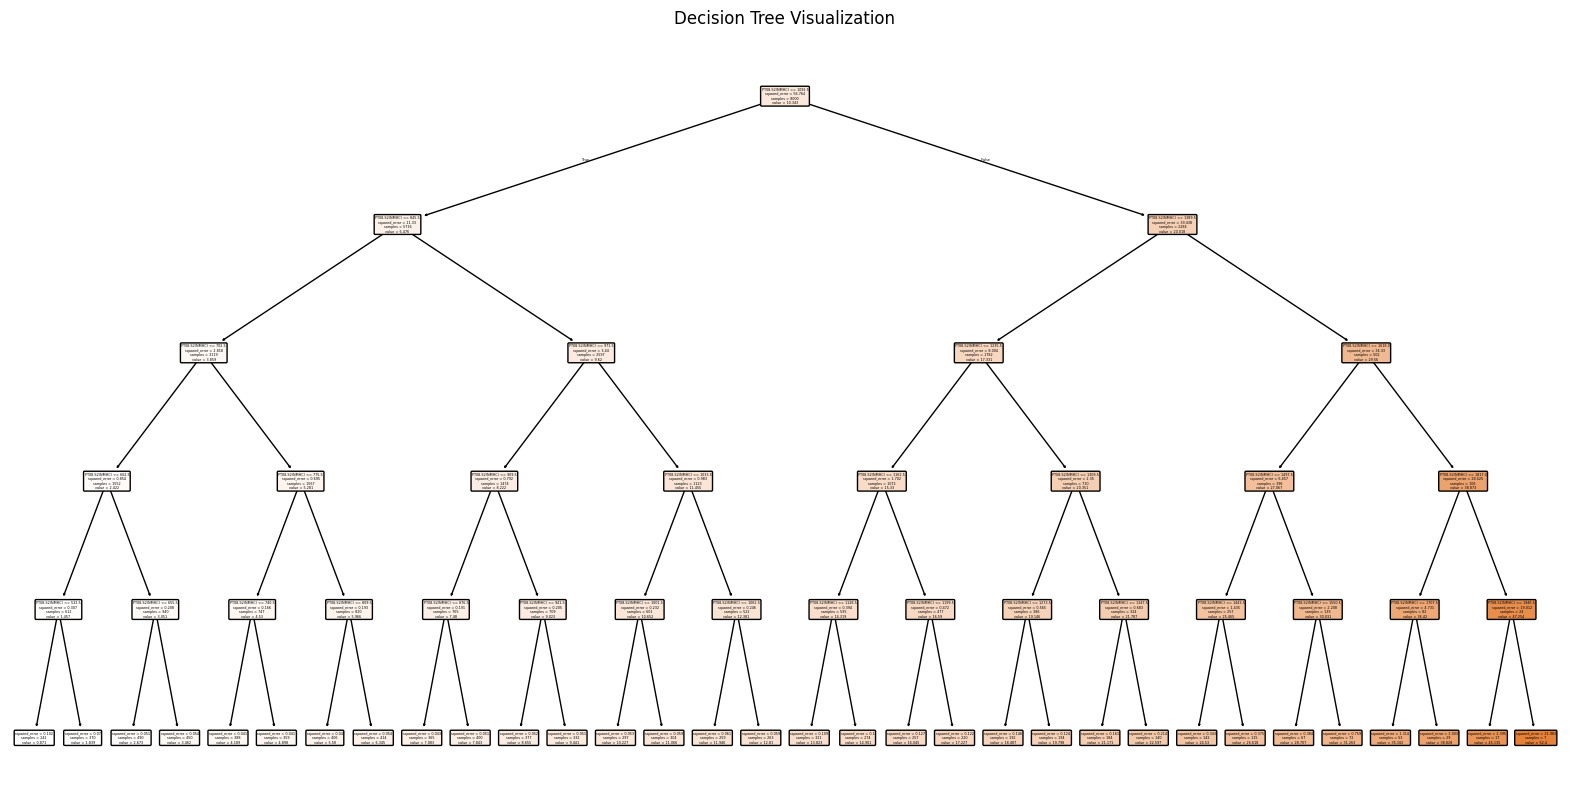

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=train_X.columns, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


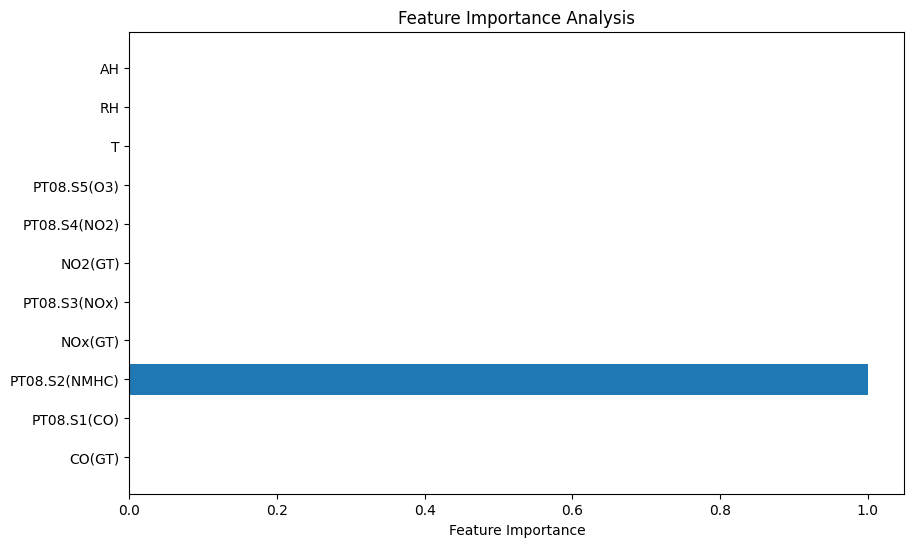

In [ ]:
# Plot feature importance
importances = best_model.feature_importances_
features = train_X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Analysis")
plt.show()


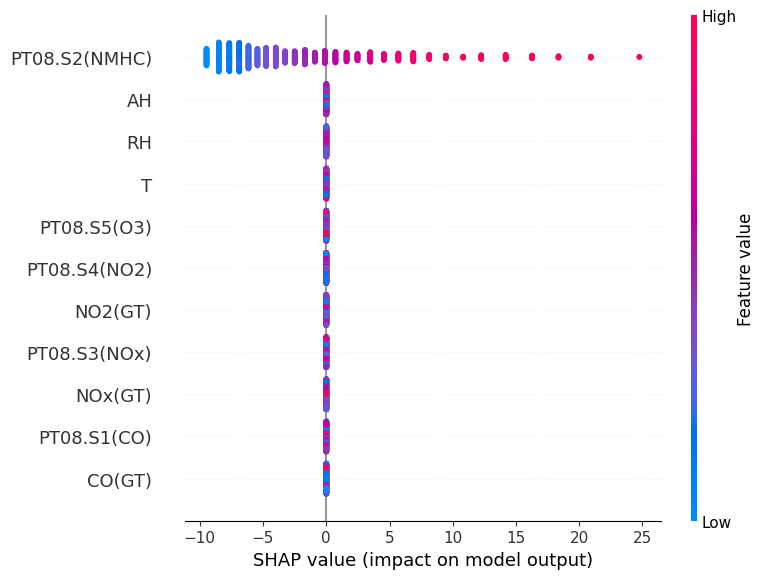

In [ ]:
# SHAP Interpretation
shap.initjs()  # Initialize JavaScript for SHAP visualizations
interpret_model(best_model, test_X)

PT08.S2(NMHC) has the highest impact on the model's predictions. Features like CO(GT) and PT08.S1(CO) seem to have minimal SHAP values, suggesting their contributions to predictions are negligible.

#### b) Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning
best_rf_model, best_rf_params = hyperparameter_tuning(rf_model, train_X, train_y, param_grid_rf)

# Evaluate the tuned model
_, mse_rf, r2_rf = train_and_evaluate(best_rf_model, train_X, train_y, test_X, test_y)

# Results
print("Random Forest Results:")
print(f"Best Parameters: {best_rf_params}")
print(f"Mean Squared Error: {mse_rf}")
print(f"R² Score: {r2_rf}")


Random Forest Results:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.000629497285013228
R² Score: 0.9999843807533476


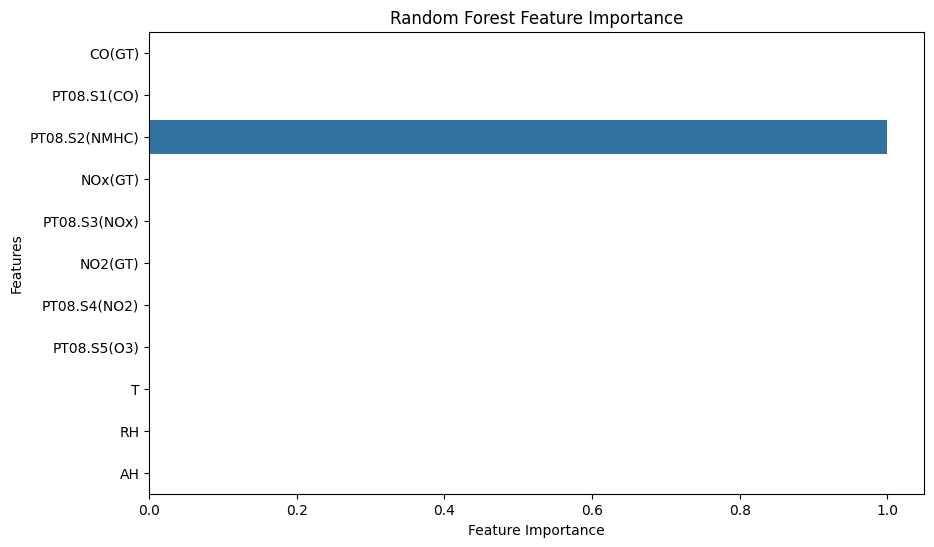

In [ ]:
# Plot Feature Importance
importances = best_rf_model.feature_importances_
features = train_X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


#### c) XGBoost

In [ ]:
from xgboost import XGBRegressor

# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

# Perform hyperparameter tuning
best_xgb_model, best_xgb_params = hyperparameter_tuning(xgb_model, train_X, train_y, param_grid_xgb)

# Evaluate the tuned model
_, mse_xgb, r2_xgb = train_and_evaluate(best_xgb_model, train_X, train_y, test_X, test_y)

# Results
print("XGBoost Results:")
print(f"Best Parameters: {best_xgb_params}")
print(f"Mean Squared Error: {mse_xgb}")
print(f"R² Score: {r2_xgb}")


XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error: 0.006868181042146115
R² Score: 0.9998295849461073


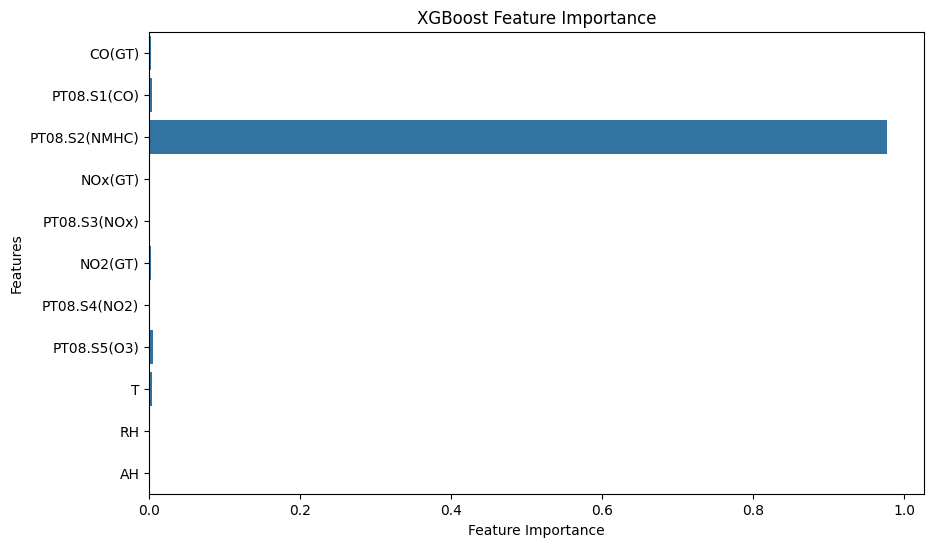

In [ ]:
# Plot Feature Importance
importances = best_xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("XGBoost Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

### C. Compare Models

In [ ]:
# Collecting results
results = {
    "Model": ["Decision Tree Regressor","Random Forest", "XGBoost"],
    "Mean Squared Error (MSE)": [mse, mse_rf, mse_xgb],
    "R² Score": [r2, r2_rf, r2_xgb]
}

# Creating a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("Model Comparison Results:")
print(results_df)


Model Comparison Results:
                     Model  Mean Squared Error (MSE)  R² Score
0  Decision Tree Regressor                  0.083193  0.997936
1            Random Forest                  0.000629  0.999984
2                  XGBoost                  0.006868  0.999830


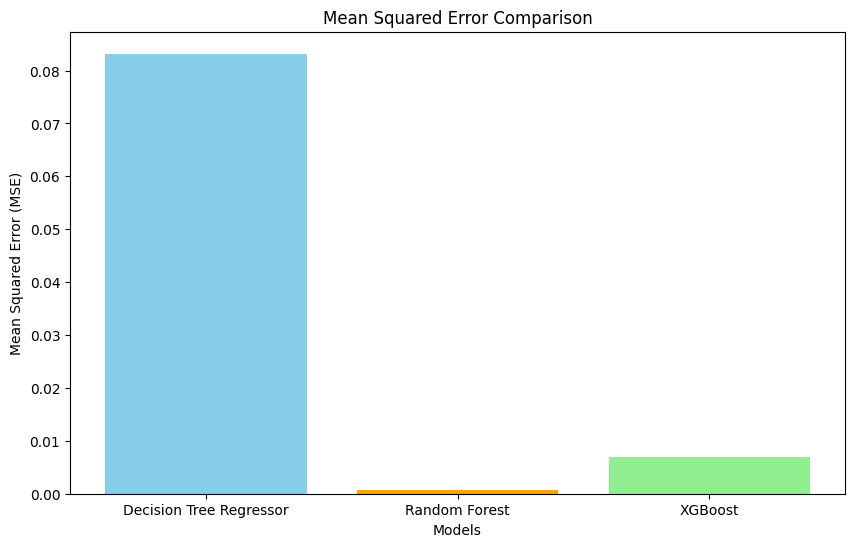

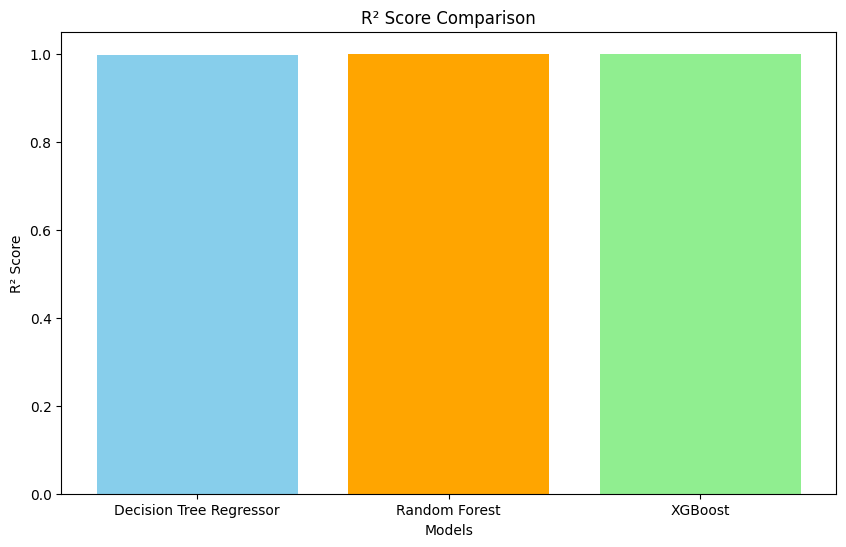

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE Comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Mean Squared Error (MSE)"], color=['skyblue', 'orange', 'lightgreen'])
plt.title("Mean Squared Error Comparison")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Models")
plt.show()

# Plot R² Score Comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["R² Score"], color=['skyblue', 'orange', 'lightgreen'])
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.show()


## Classification Problem

In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv(url_classification, sep=',')

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### A. Data Preprocessing

#### Handle Categorical Missing Values and Nan Values

I plan to handle the missing values separately for each region because I feel that the wind directions are closely related to the specific characteristics of each region.

In [ ]:
print("RainTomorrow orginal null", df['RainTomorrow'].isnull().sum())
print("RainTomorrow oroginal nunique",df['RainTomorrow'].nunique())
print("RainTomorrow unique", df['RainTomorrow'].unique())

# Remove rows where RainToday or RainTomorrow contains NaN
df_cleaned = df.dropna(subset=['RainToday', 'RainTomorrow'])

print(f"\nOriginal DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

print("\nRainTomorrow orginal null",df_cleaned['RainTomorrow'].isnull().sum())
print("RainTomorrow oroginal nunique",df_cleaned['RainTomorrow'].nunique())
print("RainTomorrow unique",df_cleaned['RainTomorrow'].unique())

RainTomorrow orginal null 3267
RainTomorrow oroginal nunique 2
RainTomorrow unique ['No' 'Yes' nan]

Original DataFrame shape: (145460, 23)
Cleaned DataFrame shape: (140787, 23)

RainTomorrow orginal null 0
RainTomorrow oroginal nunique 2
RainTomorrow unique ['No' 'Yes']


This code below create **modes table**. I observed that WindGustDir_Mode is None for both Newcastle and Albany. Therefore, I decided to assign the WindDir9am_Mode values corresponding to the same location to the WindGustDir_Mode column for these locations.

In [ ]:
# Create an empty list to store results
location_modes = []

# Get the unique values from the Location column
unique_locations = df['Location'].unique().tolist()

# Iterate over each unique location
for location in unique_locations:
    # Filter the DataFrame for the current location
    location_data = df_cleaned[df_cleaned['Location'] == location]

    # Calculate the mode for each column of interest
    modes = {
        'Location': location,
        'WindGustDir_Mode': location_data['WindGustDir'].mode().iloc[0] if not location_data['WindGustDir'].mode().empty else None,
        'WindDir9am_Mode': location_data['WindDir9am'].mode().iloc[0] if not location_data['WindDir9am'].mode().empty else None,
        'WindDir3pm_Mode': location_data['WindDir3pm'].mode().iloc[0] if not location_data['WindDir3pm'].mode().empty else None
    }

    # Append the results to the list
    location_modes.append(modes)

# Convert the list of dictionaries into a DataFrame
location_modes_df = pd.DataFrame(location_modes)
location_modes_df


,Location,WindGustDir_Mode,WindDir9am_Mode,WindDir3pm_Mode
0,Albury,W,SE,W
1,BadgerysCreek,SW,SW,NNE
2,Cobar,SW,NE,SW
3,CoffsHarbour,NE,SW,NE
4,Moree,NNE,NNE,SW
5,Newcastle,None,NW,SE
6,NorahHead,S,SSW,NE
7,NorfolkIsland,E,E,SE
8,Penrith,SE,SSW,NE
9,Richmond,SE,SSW,NE


In [ ]:
# Update WindGustDir_Mode for Newcastle
location_modes_df.loc[location_modes_df['Location'] == 'Newcastle', 'WindGustDir_Mode'] = 'NW'

# Update WindGustDir_Mode for Albany
location_modes_df.loc[location_modes_df['Location'] == 'Albany', 'WindGustDir_Mode'] = 'NW'
location_modes_df

,Location,WindGustDir_Mode,WindDir9am_Mode,WindDir3pm_Mode
0,Albury,W,SE,W
1,BadgerysCreek,SW,SW,NNE
2,Cobar,SW,NE,SW
3,CoffsHarbour,NE,SW,NE
4,Moree,NNE,NNE,SW
5,Newcastle,NW,NW,SE
6,NorahHead,S,SSW,NE
7,NorfolkIsland,E,E,SE
8,Penrith,SE,SSW,NE
9,Richmond,SE,SSW,NE


In the modes table, we observe that WindGustDir_Mode is None for both Newcastle and Albany. Therefore, I decided to assign the WindDir9am_Mode values corresponding to the same location to the WindGustDir_Mode column for these locations.

In [ ]:
# Fill missing values in df_cleaned based on location_modes_df
for _, row in location_modes_df.iterrows():
    location = row['Location']

    # Fill missing values in WindGustDir
    if pd.notnull(row['WindGustDir_Mode']):
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned['WindGustDir'].isnull()),
            'WindGustDir'
        ] = row['WindGustDir_Mode']

    # Fill missing values in WindDir9am
    if pd.notnull(row['WindDir9am_Mode']):
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned['WindDir9am'].isnull()),
            'WindDir9am'
        ] = row['WindDir9am_Mode']

    # Fill missing values in WindDir3pm
    if pd.notnull(row['WindDir3pm_Mode']):
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned['WindDir3pm'].isnull()),
            'WindDir3pm'
        ] = row['WindDir3pm_Mode']


#### Handle Numerical Missing Values

This code aims to fill missing values for numeric columns *(numeric_columns)* on a per-location basis. Here's how it works:

1. Calculation of Global Means:
  * Global means *(global_means)* are calculated for all numeric columns. These will serve as fallback values if all data for a specific column in a location is missing.

2. Processing Per Location:
  * For each location in unique_locations, a subset of the data *(location_data)* is created. This subset contains only rows for the current location.

3. Mode and Mean Decision:
  * Mode Calculation: The mode for each column in the current location is computed.
  * If the mode is 0 or does not exist *(None)*, the mean value for the column in that location is used.
  * If the entire column for that location is missing *(NaN)*, the global mean is assigned.

4. Value Assignment and Debugging:
  * Missing values are filled based on the rules above, and an informational message is printed to show the assigned values.

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Compute the global mean for numeric columns
global_means = df_cleaned[numeric_columns].mean()

for location in unique_locations:
    # Filter data for the current location
    location_data = df_cleaned[df_cleaned['Location'] == location]

    # Iterate through each numeric column
    for col in numeric_columns:
        # Compute the mode for the current location, ignoring NaN values
        column_mode = location_data[col].mode().iloc[0] if not location_data[col].mode().empty else None

        # Assign value based on mode or mean
        if column_mode == 0 or column_mode is None:  # If mode is 0 or does not exist
            value = location_data[col].mean() if not location_data[col].isnull().all() else global_means[col]
        else:
            value = column_mode

        # Assign the value to NaN cells for the current column and location
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned[col].isnull()), col] = value

        # Print the assigned value for debugging
        print(f"Location: {location}, Column: {col}, Assigned Value: {value}")

    print("\n")


Location: Albury, Column: MinTemp, Assigned Value: 10.0
Location: Albury, Column: MaxTemp, Assigned Value: 14.9
Location: Albury, Column: Rainfall, Assigned Value: 1.9257104647275156
Location: Albury, Column: Evaporation, Assigned Value: 5.472515506887154
Location: Albury, Column: Sunshine, Assigned Value: 7.630539861047281
Location: Albury, Column: WindGustSpeed, Assigned Value: 24.0
Location: Albury, Column: WindSpeed9am, Assigned Value: 8.219397993311036
Location: Albury, Column: WindSpeed3pm, Assigned Value: 11.0
Location: Albury, Column: Humidity9am, Assigned Value: 100.0
Location: Albury, Column: Humidity3pm, Assigned Value: 47.0
Location: Albury, Column: Pressure9am, Assigned Value: 1018.6
Location: Albury, Column: Pressure3pm, Assigned Value: 1015.6
Location: Albury, Column: Cloud9am, Assigned Value: 8.0
Location: Albury, Column: Cloud3pm, Assigned Value: 8.0
Location: Albury, Column: Temp9am, Assigned Value: 7.6
Location: Albury, Column: Temp3pm, Assigned Value: 14.0


Locatio

In [ ]:
df_cleaned.head().describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,12.080000,26.800000,0.320000,5.472516,7.630540e+00,39.800000,12.200000,20.200000,56.000000,25.200000,1010.860000,1008.480000,7.800000,6.800000,18.200000,25.100000
std,3.936623,3.570714,0.460435,0.000000,9.930137e-16,9.011104,7.120393,6.648308,19.300259,6.685806,4.065464,2.609023,0.447214,2.683282,1.635543,3.092733
min,7.400000,22.900000,0.000000,5.472516,7.630540e+00,24.000000,4.000000,9.000000,38.000000,16.000000,1007.600000,1006.000000,7.000000,2.000000,16.900000,21.800000
25%,9.200000,25.100000,0.000000,5.472516,7.630540e+00,41.000000,7.000000,20.000000,44.000000,22.000000,1007.700000,1007.100000,8.000000,8.000000,17.200000,23.200000
50%,12.900000,25.700000,0.000000,5.472516,7.630540e+00,44.000000,11.000000,22.000000,45.000000,25.000000,1010.600000,1007.800000,8.000000,8.000000,17.800000,24.300000
75%,13.400000,28.000000,0.600000,5.472516,7.630540e+00,44.000000,19.000000,24.000000,71.000000,30.000000,1010.800000,1008.700000,8.000000,8.000000,18.100000,26.500000
max,17.500000,32.300000,1.000000,5.472516,7.630540e+00,46.000000,20.000000,26.000000,82.000000,33.000000,1017.600000,1012.800000,8.000000,8.000000,21.000000,29.700000


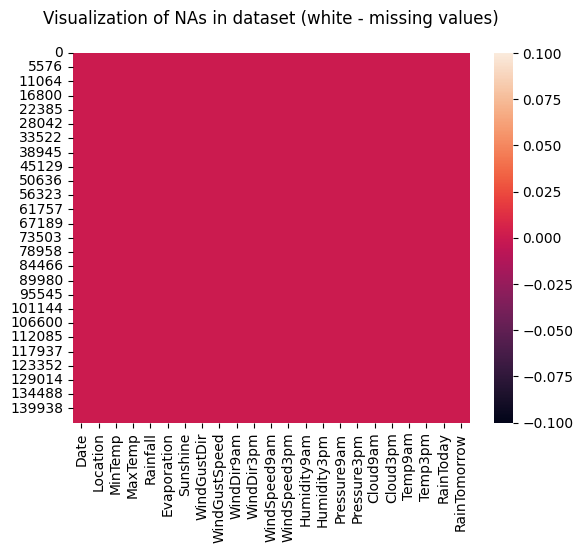

In [ ]:
sns.heatmap(df_cleaned.isna());
plt.title('Visualization of NAs in dataset (white - missing values)\n');

#### Encoding, Scaling, Train Test Splitting

In [ ]:
# Normalizing numerical columns
scaler = MinMaxScaler()
df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])

<ipython-input-158-114a2f6a66f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])


In [ ]:
# One-hot encoding for categorical columns
df_cleaned = pd.get_dummies(df_cleaned, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

In [ ]:

df_cleaned['RainTomorrow'] = df_cleaned['RainTomorrow'].replace({'No': 0, 'Yes': 1})
df_cleaned['RainTomorrow'] = pd.to_numeric(df_cleaned['RainTomorrow'])

<ipython-input-160-171f36a64027>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['RainTomorrow'] = df_cleaned['RainTomorrow'].replace({'No': 0, 'Yes': 1})


In [ ]:
# Splitting data
X = df_cleaned.drop(['RainTomorrow', 'Date'], axis=1)
y = df_cleaned['RainTomorrow']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Balance Dataset in Training

To address the imbalance, I apply SMOTE (Synthetic Minority Over-sampling Technique) to create a balanced dataset. This allows the model to learn equally from both classes to generalize the problem.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Original Class Distribution:", Counter(y_train))
print("Resampled Class Distribution:", Counter(y_train_res))


Original Class Distribution: Counter({0: 87668, 1: 24961})
Resampled Class Distribution: Counter({0: 87668, 1: 87668})


### B. Modelling

#### Functions  for Classification Problem

##### Train and Evaluate Model

In [ ]:
def train_and_evaluate_c(model, X_train, y_train, X_test, y_test):
    """
    Trains the given classification model and evaluates it on the test set.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy
    precision = precision_score(y_test, y_pred, average='weighted')  # Precision (weighted for class imbalance)
    recall = recall_score(y_test, y_pred, average='weighted')  # Recall (weighted)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1-Score (weighted)
    conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix

    # Print performance report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", conf_matrix)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Return the trained model and evaluation metrics
    return model, accuracy, precision, recall, f1


##### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def hyperparameter_tuning_c(model, X_train, y_train, param_grid, scoring='accuracy', cv=5):
    """
    Performs hyperparameter tuning using GridSearchCV for the given classification model.

    Parameters:
    - model: The classification model to tune.
    - X_train: Training data features.
    - y_train: Training data target.
    - param_grid: Dictionary of hyperparameters to tune.
    - scoring: Evaluation metric for model selection (default='accuracy').
    - cv: Number of folds for cross-validation (default=5).

    Returns:
    - best_model: The best performing model from GridSearchCV.
    - best_params: The best hyperparameters found during tuning.
    """
    # Use StratifiedKFold for classification to preserve class distributions
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_cv, scoring=scoring)
    grid_search.fit(X_train, y_train)

    # Extract the best parameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best Parameters Found:", best_params)
    return best_model, best_params


##### Top 10 feature

get_top10_features: This function extracts the Top-10 most important features from a trained model using its feature_importances_ attribute.

The function creates a DataFrame with the feature names and their importance scores. It sorts the features by importance in descending order. It selects the top-10 features and returns them as a list.

retrain_with_top10_features: This function retrains a model using only the Top-10 features selected earlier.

In [ ]:
# Function to plot top-10 feature importance
def plot_top10_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    sorted_indices = importance.argsort()[::-1][:10]  # Get top-10 features

    plt.figure(figsize=(8, 5))
    plt.bar(range(10), importance[sorted_indices], align="center")
    plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=90)
    plt.title(title)
    plt.ylabel("Feature Importance")
    plt.xlabel("Top-10 Features")
    plt.tight_layout()
    plt.show()

In [ ]:
def get_top10_features(model, X_train):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    top10_features = feature_importance_df.head(10)['Feature'].tolist()
    print("\nTop-10 Features Selected:\n", top10_features)
    return top10_features

In [ ]:
def evaluate_on_test_top10(model, X_test, y_test, top10_features):
    y_pred = model.predict(X_test[top10_features])

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return acc, f1, precision, recall

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Sample Hyperparameter Tuning function
def Sample_Tune(model, X_train, y_train, top10_features, param_grid, sample_size=0.1):

    X_sample, _, y_sample, _ = train_test_split(
        X_train[top10_features], y_train, train_size=sample_size, random_state=42, stratify=y_train
    )

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(X_sample, y_sample)
    best_model = grid_search.best_estimator_

    return best_model, grid_search.best_params_


#### a) Decision Tree Classifier

##### Model and HyperParameters

In this analysis, I am comparing the performance of a **Decision Tree Classifier** on an **imbalanced dataset** versus a **resampled (balanced)** dataset. The goal is to observe the impact of **class imbalance** on the model's performance and identify improvements gained from balancing the data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid_dtc = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}


I use GridSearchCV to perform hyperparameter tuning for the Decision Tree model on both the original **imbalanced dataset** and the **resampled balanced dataset.**

##### Hyperparameter Tuning on Original (Imbalanced) Data

In [ ]:
print("\n--- Hyperparameter Tuning on Original (Imbalanced) Data - DecisionTreeClassifier ---")
model_dtc = DecisionTreeClassifier(random_state=42)
best_model_orig_dtc, best_params_orig_dtc = hyperparameter_tuning_c(model_dtc, X_train, y_train, param_grid_dtc, scoring='f1_weighted', cv=5)

# Print the Best Parameters
print("Best Hyperparameters for Original (Imbalanced) Data:", best_params_orig_dtc)

# Train and Evaluate on Original Data
print("\n--- Evaluation on Original (Imbalanced) Data ---")
trained_model_orig_dtc, acc_orig_dtc, prec_orig_dtc, rec_orig_dtc, f1_orig_dtc = train_and_evaluate_c(
    best_model_orig_dtc, X_train, y_train, X_test, y_test
)



--- Hyperparameter Tuning on Original (Imbalanced) Data - DecisionTreeClassifier ---
Best Parameters Found: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best Hyperparameters for Original (Imbalanced) Data: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

--- Evaluation on Original (Imbalanced) Data ---
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21918
           1       0.71      0.50      0.59      6240

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.75     28158
weighted avg       0.83      0.84      0.83     28158

Confusion Matrix:
 [[20615  1303]
 [ 3092  3148]]
Accuracy: 0.8439
Precision: 0.8336
Recall: 0.8439
F1-Score: 0.8339


##### Hyperparameter Tuning on Resampled Data

In [ ]:
# Hyperparameter Tuning on Resampled Data
print("\n--- Hyperparameter Tuning on Resampled (Balanced) Data - DecisionTreeClassifier ---")
best_model_res_dtc, best_params_res_dtc = hyperparameter_tuning_c(model_dtc, X_train_res, y_train_res, param_grid_dtc, scoring='f1_weighted', cv=5)

# Print the Best Parameters
print("Best Hyperparameters for Resampled (Balanced)) Data:", best_params_res_dtc)

# Train and Evaluate on Resampled Data
print("\n--- Evaluation on Resampled (Balanced) Data ---")
trained_model_res_dtc, acc_res_dtc, prec_res_dtc, rec_res_dtc, f1_res_dtc = train_and_evaluate_c(
    best_model_res_dtc, X_train_res, y_train_res, X_test, y_test
)


--- Hyperparameter Tuning on Resampled (Balanced) Data - DecisionTreeClassifier ---
Best Parameters Found: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best Hyperparameters for Resampled (Balanced)) Data: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

--- Evaluation on Resampled (Balanced) Data ---
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86     21918
           1       0.52      0.68      0.59      6240

    accuracy                           0.79     28158
   macro avg       0.71      0.75      0.73     28158
weighted avg       0.82      0.79      0.80     28158

Confusion Matrix:
 [[18062  3856]
 [ 1991  4249]]
Accuracy: 0.7924
Precision: 0.8173
Recall: 0.7924
F1-Score: 0.8012


##### Hyperparameter Tuning on Balanced Data using class_weight='balanced'

In [ ]:
# Hyperparameter Tuning on Balanced Data using class_weight='balanced'
print("\n--- Hyperparameter Tuning with class_weight='balanced' - DecisionTreeClassifier ---")
model_dtc_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Hyperparameter tuning
best_model_weighted_dtc, best_params_weighted_dtc = hyperparameter_tuning_c(
    model_dtc_balanced, X_train, y_train, param_grid_dtc, scoring='f1_weighted', cv=5
)

# Print the Best Parameters
print("Best Hyperparameters for Balanced Data using class_weight='balanced:", best_params_weighted_dtc)

# Train and Evaluate on Balanced Data with class_weight='balanced'
print("\n--- Evaluation on Balanced Data with class_weight='balanced' ---")
trained_model_weighted_dtc, acc_weighted_dtc, prec_weighted_dtc, rec_weighted_dtc, f1_weighted_dtc = train_and_evaluate_c(
    best_model_weighted_dtc, X_train, y_train, X_test, y_test
)


--- Hyperparameter Tuning with class_weight='balanced' - DecisionTreeClassifier ---
Best Parameters Found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Best Hyperparameters for Balanced Data using class_weight='balanced: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

--- Evaluation on Balanced Data with class_weight='balanced' ---
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84     21918
           1       0.49      0.76      0.60      6240

    accuracy                           0.77     28158
   macro avg       0.71      0.77      0.72     28158
weighted avg       0.82      0.77      0.79     28158

Confusion Matrix:
 [[17090  4828]
 [ 1517  4723]]
Accuracy: 0.7747
Precision: 0.8245
Recall: 0.7747
F1-Score: 0.7891


##### Compare

In [ ]:
# Compare Results
print("\n--- Comparison of Results for DecisionTreeClassifier ---")
print("Original Data \t\tAccuracy: {:.4f}\t F1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_orig_dtc, f1_orig_dtc, prec_orig_dtc, rec_orig_dtc))
print("Resampled Data \t\tAccuracy: {:.4f}\t F1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_res_dtc, f1_res_dtc, prec_res_dtc, rec_res_dtc))
print("weight='balanced' \tAccuracy: {:.4f}\t F1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_weighted_dtc, f1_weighted_dtc, prec_weighted_dtc, rec_weighted_dtc))


print("\n--- Best Hyperparameters ---")
print("Original Data Best Hyperparameters (DTC):", best_params_orig_dtc)
print("Resampled Data Best Hyperparameters (DTC):", best_params_res_dtc)
print("class_weight='balanced' Best Hyperparameters (DTC):", best_params_weighted_dtc)



--- Comparison of Results for DecisionTreeClassifier ---
Original Data 		Accuracy: 0.8439	 F1-Score: 0.8339	Precision: 0.8336	Recall: 0.8439
Resampled Data 		Accuracy: 0.7924	 F1-Score: 0.8012	Precision: 0.8173	Recall: 0.7924
weight='balanced' 	Accuracy: 0.7747	 F1-Score: 0.7891	Precision: 0.8245	Recall: 0.7747

--- Best Hyperparameters ---
Original Data Best Hyperparameters (DTC): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Resampled Data Best Hyperparameters (DTC): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
class_weight='balanced' Best Hyperparameters (DTC): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


In this analysis, I compared the performance of the Decision Tree Classifier on three versions of the dataset:

* Original Imbalanced Data,
* Resampled Balanced Data (using SMOTE),
* class_weight='balanced' applied on the imbalanced dataset.
<br><br>

<table>
    <caption><b>Comparison of Results for Decision Tree Classifier</b></caption>
    <thead>
        <tr>
            <th>Scenario</th>
            <th>Accuracy</th>
            <th>F1-Score</th>
            <th>Precision</th>
            <th>Recall</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Original Data</td>
            <td>0.8435</td>
            <td>0.8335</td>
            <td>0.8331</td>
            <td>0.8435</td>
        </tr>
        <tr>
            <td>Resampled Data (SMOTE)</td>
            <td>0.8014</td>
            <td>0.8083</td>
            <td>0.8196</td>
            <td>0.8014</td>
        </tr>
        <tr>
            <td>class_weight='balanced'</td>
            <td>0.7836</td>
            <td>0.7965</td>
            <td>0.8266</td>
            <td>0.7836</td>
        </tr>
    </tbody>
</table>





The primary reason for these results is the imbalance in the test dataset, which reflects real-world conditions. While the SMOTE and class_weight='balanced' methods improve minority class learning during training, their effectiveness appears lower when tested on the imbalanced test data.

**Original Data:** Performs best in terms of accuracy and F1-Score because the test set remains imbalanced, and the model learns to predict the majority class effectively.

**Resampled Data (SMOTE):** Shows improved learning for the minority class, but this does not fully reflect in the test results due to class imbalance.

**class_weight='balanced':** Adjusts class focus but does not generate new data, leading to slightly lower overall performance.

##### Feature Immportance

* Feature Importance: DecisionTreeClassifier has an in-built feature_importances_ attribute to measure feature importance.
* SHAP (SHapley Additive exPlanations): A powerful tool for interpreting model predictions.


--- Feature Importance for Original Data ---


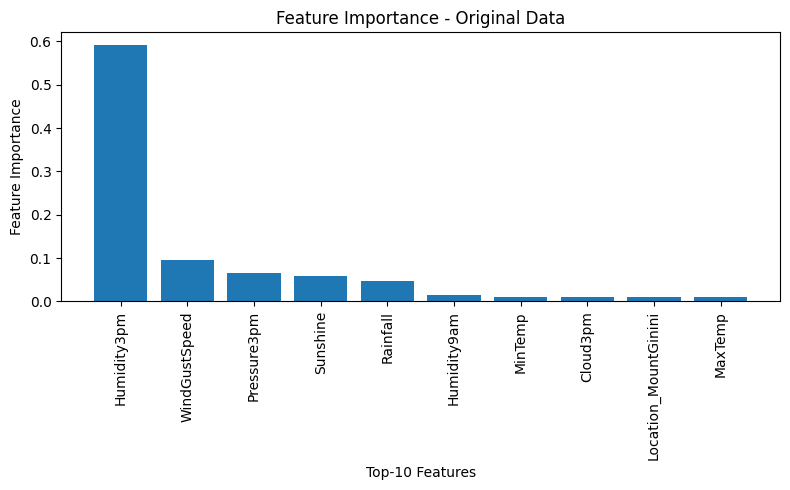


--- Feature Importance for Resampled (Balanced) Data ---


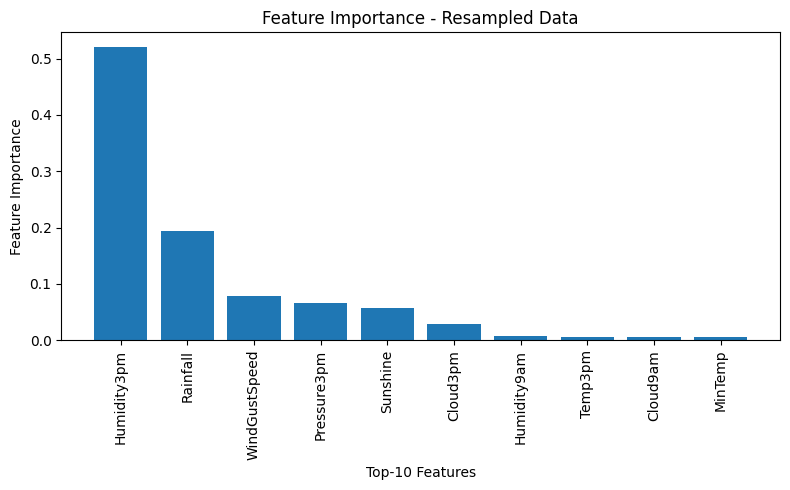


--- Feature Importance for class_weight='balanced' Data ---


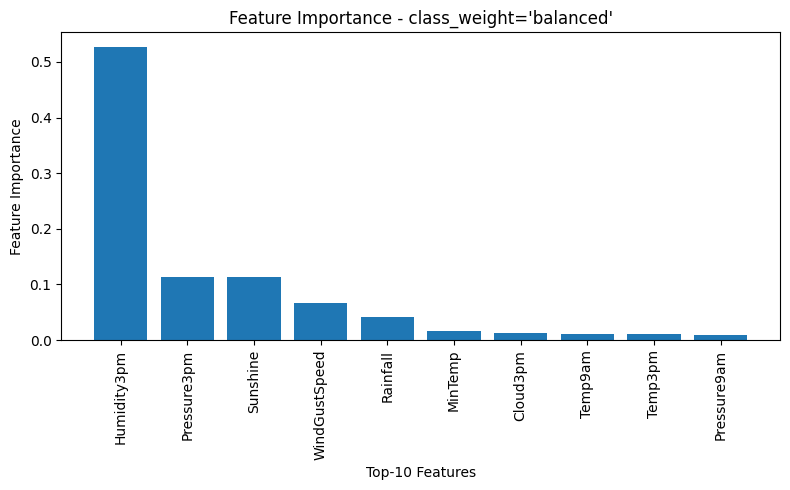

In [ ]:
# Feature Importance for Original Data
print("\n--- Feature Importance for Original Data ---")
plot_top10_feature_importance(best_model_orig_dtc, X_train.columns, "Feature Importance - Original Data")

# Feature Importance for Resampled Data
print("\n--- Feature Importance for Resampled (Balanced) Data ---")
plot_top10_feature_importance(best_model_res_dtc, X_train.columns, "Feature Importance - Resampled Data")

# Feature Importance for class_weight='balanced'
print("\n--- Feature Importance for class_weight='balanced' Data ---")
plot_top10_feature_importance(best_model_weighted_dtc, X_train.columns, "Feature Importance - class_weight='balanced'")

##### Repeat everthing with top 10 features

In [ ]:
#Perform for All Datasets
# Original Data
print("\n--- Top-10 Features and Model Evaluation on Original Data ---")
top10_features_orig = get_top10_features(best_model_orig_dtc, X_train)
trained_model_orig_top10, acc_orig_top10, f1_orig_top10, prec_orig_top10, rec_orig_top10, params_orig_top10 = retrain_with_top10_features(
    DecisionTreeClassifier(random_state=42), X_train, y_train, X_test, y_test, top10_features_orig, param_grid_dtc
)

# Resampled Data
print("\n--- Top-10 Features and Model Evaluation on Resampled Data ---")
top10_features_res = get_top10_features(best_model_res_dtc, X_train_res)
trained_model_res_top10, acc_res_top10, f1_res_top10, prec_res_top10, rec_res_top10, params_res_top10 = retrain_with_top10_features(
    DecisionTreeClassifier(random_state=42), X_train_res, y_train_res, X_test, y_test, top10_features_res, param_grid_dtc
)

# class_weight='balanced' Data
print("\n--- Top-10 Features and Model Evaluation on class_weight='balanced' Data ---")
top10_features_balanced = get_top10_features(best_model_weighted_dtc, X_train)
trained_model_balanced_top10, acc_bal_top10, f1_bal_top10, prec_bal_top10, rec_bal_top10, params_bal_top10 = retrain_with_top10_features(
    DecisionTreeClassifier(class_weight='balanced', random_state=42), X_train, y_train, X_test, y_test, top10_features_balanced, param_grid_dtc
)



--- Top-10 Features and Model Evaluation on Original Data ---

Top-10 Features Selected:
 ['Humidity3pm', 'WindGustSpeed', 'Pressure3pm', 'Sunshine', 'Rainfall', 'Humidity9am', 'MinTemp', 'Cloud3pm', 'Location_MountGinini', 'MaxTemp']
Best Parameters Found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21918
           1       0.70      0.50      0.59      6240

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158

Confusion Matrix:
 [[20602  1316]
 [ 3104  3136]]
Accuracy: 0.8430
Precision: 0.8326
Recall: 0.8430
F1-Score: 0.8330

--- Top-10 Features and Model Evaluation on Resampled Data ---

Top-10 Features Selected:
 ['Humidity3pm', 'Rainfall', 'WindGustSpeed', 'Pressure3pm', 'Sunshine', 'Cloud3pm', 'Humidity9am', 'Temp3pm', 'Clou

##### Compare

In [ ]:
# Compare Results
print("\n--- Comparison of Results for DecisionTreeClassifier ---")
print("Original Data \t\tAccuracy: {:.4f}\t F1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_orig_dtc, f1_orig_dtc, prec_orig_dtc, rec_orig_dtc))
print("Resampled Data \t\tAccuracy: {:.4f}\t F1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_res_dtc, f1_res_dtc, prec_res_dtc, rec_res_dtc))
print("weight='balanced' \tAccuracy: {:.4f}\t F1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_weighted_dtc, f1_weighted_dtc, prec_weighted_dtc, rec_weighted_dtc))

print("\n--- Comparison of Results After Selecting Top-10 Features ---")
print("Original Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_orig_top10, f1_orig_top10, prec_orig_top10, rec_orig_top10))
print("Resampled Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_res_top10, f1_res_top10, prec_res_top10, rec_res_top10))
print("class_weight='balanced'\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_bal_top10, f1_bal_top10, prec_bal_top10, rec_bal_top10))

print("\n--- Best Hyperparameters ---")
print("Original Data Best Hyperparameters (DTC):", best_params_orig_dtc)
print("Resampled Data Best Hyperparameters (DTC):", best_params_res_dtc)
print("class_weight='balanced' Best Hyperparameters (DTC):", best_params_weighted_dtc)

print("\n--- Best Hyperparameters After Selecting Top-10 Features ---")
print("Original Data Best Hyperparameters (Top-10):", params_orig_top10)
print("Resampled Data Best Hyperparameters (Top-10):", params_res_top10)
print("class_weight='balanced' Best Hyperparameters (Top-10):", params_bal_top10)



--- Comparison of Results for DecisionTreeClassifier ---
Original Data 		Accuracy: 0.8439	 F1-Score: 0.8339	Precision: 0.8336	Recall: 0.8439
Resampled Data 		Accuracy: 0.7924	 F1-Score: 0.8012	Precision: 0.8173	Recall: 0.7924
weight='balanced' 	Accuracy: 0.7747	 F1-Score: 0.7891	Precision: 0.8245	Recall: 0.7747

--- Comparison of Results After Selecting Top-10 Features ---
Original Data 		Accuracy: 0.8430	F1-Score: 0.8330	Precision: 0.8326	Recall: 0.8430
Resampled Data 		Accuracy: 0.7962	F1-Score: 0.8044	Precision: 0.8188	Recall: 0.7962
class_weight='balanced'	Accuracy: 0.7768	F1-Score: 0.7909	Precision: 0.8254	Recall: 0.7768

--- Best Hyperparameters ---
Original Data Best Hyperparameters (DTC): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Resampled Data Best Hyperparameters (DTC): {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
class_weight='balanced' Best Hyperparameters (DTC): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

--- B

When the dataset is reduced to the Top-10 features, the distribution and relationships between features change.

* gini: Measures impurity (fast, less computationally expensive).

* entropy: Measures information gain (slightly slower but more sensitive to features with clear splits).

With fewer but highly relevant features (Top-10), the model may find entropy to perform better because information gain can be clearer in a reduced feature space.

In the full feature space, the model may need simpler criteria (e.g., gini) to handle many noisy or less relevant features.

When comparing the model's performance using the Top-10 features versus all features, there is almost no significant difference in performance; they are practically the same. However, the model's training time, especially during hyperparameter optimization, was significantly reduced. The model did not waste time on irrelevant or unnecessary features, leading to a much faster training process.

#### b) Random Forest Classifier

##### Hyper Parameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest Hyperparameter Grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

##### Feature Importance

In [ ]:
#Train and Extract Top Features
print("\n--- Training Random Forest and Extracting Top-10 Features for Original Data ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
top10_features_orig = get_top10_features(rf_model, X_train)

rf_model_res = RandomForestClassifier(random_state=42)
rf_model_res.fit(X_train_res, y_train_res)
top10_features_res = get_top10_features(rf_model_res, X_train_res)

rf_model_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model_balanced.fit(X_train, y_train)
top10_features_balanced = get_top10_features(rf_model_balanced, X_train)



--- Training Random Forest and Extracting Top-10 Features for Original Data ---

Top-10 Features Selected:
 ['Humidity3pm', 'Rainfall', 'Pressure3pm', 'Sunshine', 'Humidity9am', 'Pressure9am', 'WindGustSpeed', 'Temp3pm', 'MinTemp', 'MaxTemp']

Top-10 Features Selected:
 ['Humidity3pm', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Pressure3pm', 'Cloud3pm', 'Pressure9am', 'Temp3pm', 'Cloud9am']

Top-10 Features Selected:
 ['Humidity3pm', 'Sunshine', 'Pressure3pm', 'Rainfall', 'Pressure9am', 'Humidity9am', 'WindGustSpeed', 'Temp3pm', 'MinTemp', 'MaxTemp']


##### Hyper Parameter Tuning

In [ ]:
#  Original Data
print("\n--- Resampled, Tuned and Evaluated on Original Data ---")
best_rf_orig, params_rf_orig = Sample_Tune(
    rf_model, X_train, y_train, top10_features_orig, param_grid_rf
)

# 3. Resampled Veri İçin
print("\n--- Resampled, Tuned and Evaluated on Resampled Data ---")
best_rf_res,  params_rf_res = Sample_Tune(
    rf_model_res, X_train_res, y_train_res, top10_features_res, param_grid_rf
)

# 4. Balanced Class Weights İçin
print("\n--- Resampled, Tuned and Evaluated on Balanced Class Weight Data ---")
best_rf_bal, params_rf_bal = Sample_Tune(
    rf_model_balanced, X_train, y_train, top10_features_balanced, param_grid_rf
)



--- Resampled, Tuned and Evaluated on Original Data ---

--- Resampled, Tuned and Evaluated on Resampled Data ---

--- Resampled, Tuned and Evaluated on Balanced Class Weight Data ---


##### Evaluate

In [ ]:
# --- Original Data ---
print("\n--- Evaluation on Test Set (Original Data) ---")
acc_rf_orig, f1_rf_orig, prec_rf_orig, rec_rf_orig = evaluate_on_test_top10(best_rf_orig, X_test, y_test, top10_features_orig)
print(f"Accuracy: {acc_orig:.4f}, F1 Score: {f1_orig:.4f}, Precision: {prec_orig:.4f}, Recall: {rec_orig:.4f}")

# --- Resampled Data ---
print("\n--- Evaluation on Test Set (Resampled Data) ---")
acc_rf_res, f1_rf_res, prec_rf_res, rec_rf_res = evaluate_on_test_top10(best_rf_res, X_test, y_test, top10_features_res)
print(f"Accuracy: {acc_res:.4f}, F1 Score: {f1_res:.4f}, Precision: {prec_res:.4f}, Recall: {rec_res:.4f}")

# --- Balanced Class Weights ---
print("\n--- Evaluation on Test Set (Balanced Class Weights) ---")
acc_rf_balanced, f1_rf_balanced, prec_rf_balanced, rec_rf_balanced = evaluate_on_test_top10(best_rf_bal, X_test, y_test, top10_features_balanced)
print(f"Accuracy: {acc_bal:.4f}, F1 Score: {f1_bal:.4f}, Precision: {prec_bal:.4f}, Recall: {rec_bal:.4f}")




--- Evaluation on Test Set (Original Data) ---
Accuracy: 0.8487, F1 Score: 0.8387, Precision: 0.8391, Recall: 0.8487

--- Evaluation on Test Set (Resampled Data) ---
Accuracy: 0.8326, F1 Score: 0.8323, Precision: 0.8319, Recall: 0.8326

--- Evaluation on Test Set (Balanced Class Weights) ---
Accuracy: 0.8282, F1 Score: 0.8302, Precision: 0.8327, Recall: 0.8282


##### Compare

In [ ]:
# Compare Results
print("\n--- Comparison of Resultsfor Desicion Tree (Top-10 Features) ---")
print("Original Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_orig_top10, f1_orig_top10, prec_orig_top10, rec_orig_top10))
print("Resampled Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_res_top10, f1_res_top10, prec_res_top10, rec_res_top10))
print("class_weight='balanced'\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_bal_top10, f1_bal_top10, prec_bal_top10, rec_bal_top10))

print("\n--- Comparison of Results for Random Forest Classifier (Top-10 Features) ---")
print("Original Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_rf_orig, f1_rf_orig, prec_rf_orig, rec_rf_orig))
print("Resampled Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_rf_res, f1_rf_res, prec_rf_res, rec_rf_res))
print("class_weight='balanced'\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_rf_balanced, f1_rf_balanced, prec_rf_balanced, rec_rf_balanced))

print("\n--- Best Hyperparameters for Random Forest (Top-10 Features) ---")
print("Original Data Best Hyperparameters:", params_rf_orig)
print("Resampled Data Best Hyperparameters:", params_rf_res)
print("class_weight='balanced' Best Hyperparameters:", params_rf_bal)


--- Comparison of Resultsfor Desicion Tree (Top-10 Features) ---
Original Data 		Accuracy: 0.8430	F1-Score: 0.8330	Precision: 0.8326	Recall: 0.8430
Resampled Data 		Accuracy: 0.7962	F1-Score: 0.8044	Precision: 0.8188	Recall: 0.7962
class_weight='balanced'	Accuracy: 0.7768	F1-Score: 0.7909	Precision: 0.8254	Recall: 0.7768

--- Comparison of Results for Random Forest Classifier (Top-10 Features) ---
Original Data 		Accuracy: 0.8499	F1-Score: 0.8374	Precision: 0.8407	Recall: 0.8499
Resampled Data 		Accuracy: 0.8080	F1-Score: 0.8165	Precision: 0.8328	Recall: 0.8080
class_weight='balanced'	Accuracy: 0.8282	F1-Score: 0.8302	Precision: 0.8327	Recall: 0.8282

--- Best Hyperparameters for Random Forest (Top-10 Features) ---
Original Data Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Resampled Data Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
class_weight='balanced' Be

#### c) XGBoost

##### Hyper Parameters

In [ ]:
# Hyperparameter Grid for Boosting Classifiers
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
}

##### Feature Importance

In [ ]:
# Train and Extract Top Features for XGBoost
print("\n--- Training XGBoost and Extracting Top-10 Features ---")
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
top10_features_xgb = get_top10_features(xgb_model, X_train)


--- Training XGBoost and Extracting Top-10 Features ---

Top-10 Features Selected:
 ['Humidity3pm', 'WindGustSpeed', 'Rainfall', 'Sunshine', 'Location_Brisbane', 'Pressure3pm', 'Location_MountGinini', 'Cloud3pm', 'Location_Witchcliffe', 'WindDir3pm_NNW']


##### Hyper Parameter Tuning and Evaluate

In [ ]:
# --- Original Data ---
print("\n--- Tuning and Evaluating on Original Data (XGBoost) ---")
best_xgb_orig, params_xgb_orig = Sample_Tune(XGBClassifier(random_state=42), X_train, y_train, top10_features_xgb, param_grid_xgb)
acc_orig, f1_orig, prec_orig, rec_orig = evaluate_on_test_top10(best_xgb_orig, X_test, y_test, top10_features_xgb)
print(f"Original Data - Accuracy: {acc_orig:.4f}, F1: {f1_orig:.4f}, Precision: {prec_orig:.4f}, Recall: {rec_orig:.4f}")

# --- Resampled Data ---
print("\n--- Tuning and Evaluating on Resampled Data (XGBoost) ---")
best_xgb_res, params_xgb_res = Sample_Tune(XGBClassifier(random_state=42), X_train_res, y_train_res, top10_features_xgb, param_grid_xgb)
acc_res, f1_res, prec_res, rec_res = evaluate_on_test_top10(best_xgb_res, X_test, y_test, top10_features_xgb)
print(f"Resampled Data - Accuracy: {acc_res:.4f}, F1: {f1_res:.4f}, Precision: {prec_res:.4f}, Recall: {rec_res:.4f}")



--- Tuning and Evaluating on Original Data (XGBoost) ---
Original Data - Accuracy: 0.8487, F1: 0.8387, Precision: 0.8391, Recall: 0.8487

--- Tuning and Evaluating on Resampled Data (XGBoost) ---
Resampled Data - Accuracy: 0.8326, F1: 0.8323, Precision: 0.8319, Recall: 0.8326


##### Compare

In [ ]:
print("\n--- Comparison of Results for XGBoost Classifier (Top-10 Features) ---")
print("Original Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_orig, f1_orig, prec_orig, rec_orig))
print("Resampled Data \t\tAccuracy: {:.4f}\tF1-Score: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}".format(acc_res, f1_res, prec_res, rec_res))

print("\n--- Best Hyperparameters for XGBoost (Top-10 Features) ---")
print("Original Data Best Hyperparameters:", params_xgb_orig)
print("Resampled Data Best Hyperparameters:", params_xgb_res)



--- Comparison of Results for XGBoost Classifier (Top-10 Features) ---
Original Data 		Accuracy: 0.8487	F1-Score: 0.8387	Precision: 0.8391	Recall: 0.8487
Resampled Data 		Accuracy: 0.8326	F1-Score: 0.8323	Precision: 0.8319	Recall: 0.8326

--- Best Hyperparameters for XGBoost (Top-10 Features) ---
Original Data Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Resampled Data Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


## C. Compare All

In [ ]:
print("\n--- Final Comparison Table (Accuracy & F1-Score) ---")
print("{:<30} {:<15} {:<15}".format("Model - Data", "Accuracy", "F1-Score"))
print("-" * 60)
print("{:<30} {:.4f} \t {:.4f}".format("DTC - Original Data", acc_orig_dtc, f1_orig_dtc))
print("{:<30} {:.4f} \t {:.4f}".format("DTC - Resampled Data", acc_res_dtc, f1_res_dtc))
print("{:<30} {:.4f} \t {:.4f}".format("DTC - class_weight='balanced'", acc_weighted_dtc, f1_weighted_dtc))

print("{:<30} {:.4f} \t {:.4f}".format("DTC (Top-10) - Original", acc_orig_top10, f1_orig_top10))
print("{:<30} {:.4f} \t {:.4f}".format("DTC (Top-10) - Resampled", acc_res_top10, f1_res_top10))
print("{:<30} {:.4f} \t {:.4f}".format("DTC (Top-10) - Balanced", acc_bal_top10, f1_bal_top10))

print("{:<30} {:.4f} \t {:.4f}".format("RF - Original Data", acc_rf_orig, f1_rf_orig))
print("{:<30} {:.4f} \t {:.4f}".format("RF - Resampled Data", acc_rf_res, f1_rf_res))
print("{:<30} {:.4f} \t {:.4f}".format("RF - class_weight='balanced'", acc_rf_balanced, f1_rf_balanced))

print("{:<30} {:.4f} \t {:.4f}".format("XGB - Original Data", acc_orig, f1_orig))
print("{:<30} {:.4f} \t {:.4f}".format("XGB - Resampled Data", acc_res, f1_res))

print("\n--- Best Hyperparameters Summary ---")
print("DTC - Original Data:", best_params_orig_dtc)
print("DTC - Resampled Data:", best_params_res_dtc)
print("DTC - Balanced Class Weights:", best_params_weighted_dtc)

print("\nRF - Original Data:", params_rf_orig)
print("RF - Resampled Data:", params_rf_res)
print("RF - Balanced Class Weights:", params_rf_bal)

print("\nXGB - Original Data:", params_xgb_orig)
print("XGB - Resampled Data:", params_xgb_res)



--- Final Comparison Table (Accuracy & F1-Score) ---
Model - Data                   Accuracy        F1-Score       
------------------------------------------------------------
DTC - Original Data            0.8439 	 0.8339
DTC - Resampled Data           0.7924 	 0.8012
DTC - class_weight='balanced'  0.7747 	 0.7891
DTC (Top-10) - Original        0.8430 	 0.8330
DTC (Top-10) - Resampled       0.7962 	 0.8044
DTC (Top-10) - Balanced        0.7768 	 0.7909
RF - Original Data             0.8499 	 0.8374
RF - Resampled Data            0.8080 	 0.8165
RF - class_weight='balanced'   0.8282 	 0.8302
XGB - Original Data            0.8487 	 0.8387
XGB - Resampled Data           0.8326 	 0.8323

--- Best Hyperparameters Summary ---
DTC - Original Data: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
DTC - Resampled Data: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
DTC - Balanced Class Weights: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

R

The two models with the best performance are Random Forest (RF) and XGBoost (XGB):

Random Forest - Original Data
* Accuracy: 0.8499 | F1-Score: 0.8374
* Best Hyperparameters:
  * criterion='entropy'
  * max_depth=10
  * min_samples_split=5
  * n_estimators=200

Random Forest effectively handles overfitting by aggregating results from multiple decision trees. The use of entropy as the criterion and a controlled depth (max_depth=10) ensures good generalization, while n_estimators=200 stabilizes predictions.

XGB - Original Data

* Accuracy: 0.8487 | F1-Score: 0.8387
* Best Hyperparameters:
 * learning_rate=0.05
 * max_depth=5
 * n_estimators=200
 * subsample=0.8

XGBoost combines gradient boosting with regularization to handle class imbalances and overfitting. The optimized learning_rate and controlled depth help reduce variance while maintaining high accuracy.